# Sparse Regression in HTG Mouse Series

The idea here is to regress the genotyped CAG length using the gene expression data.  To do this we'll use a simple sparse regression technique.  The elastic net is a ridge + lasso penalized linear regression, and glmnet imlpements a very nice version.

## Required Pacakes

* caret makes splitting the data up in to test and train groups easy
* ggplot2 for ggplots
* glmnet for regression
* tidyr for data frame manipulation

In [2]:
packages <- c('caret',
              'ggplot2',
              'glmnet',
              'tidyr'
             )

# load package is it exists, if not, install it and then load it
for (package in packages) {
    if (!require(package, character.only=TRUE, quietly=TRUE)) {
        install.packages(package, repos='http://cran.us.r-project.org')
        require(package, character.only=TRUE, quietly=TRUE)
    }
}

(.packages())

[1] "tidyr"     "glmnet"    "foreach"   "Matrix"    "caret"     "ggplot2"  
 [7] "lattice"   "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[13] "methods"   "base"

## Load up data

different normalizations i've prepared:
* raw counts
* nonparanormal
* log(raw counts + 1)

In [3]:
data_dir <- "/users/rdonovan/shared_data/hd_mouse_allelic_series"
data_files_to_load <- list.files(path=data_dir)

In [4]:
for (data_file in data_files_to_load) {
    full_data_path <- file.path(data_dir,data_file)
    print(full_data_path)
    load(full_data_path)
}

ls()

[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_RAW.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_RAW.Rdata"


[1] "all_mrna_data_logp1"    "all_mrna_data_npn"      "all_mrna_data_npn_tidy"
 [4] "all_mrna_data_raw"      "all_mrna_data_raw_tidy" "data_dir"              
 [7] "data_file"              "data_files_to_load"     "full_data_path"        
[10] "package"                "packages"               "q"                     
[13] "quit"

## Modify data slightly

The wt mice all have q-length of 7, but aren't annotated correctly in the data (I think), so fix that

we'll use the log transformed counts, though better normalizations are certainly possible

In [5]:
wt_mice_inds <- (all_mrna_data_logp1$GenoType == 'WT')
all_mrna_data_logp1[wt_mice_inds,c('Genotyped.CAG')] <- 7
all_mrna_data_logp1[wt_mice_inds,c('Numeric.Q')] <- 7

table(all_mrna_data_logp1$Numeric.Q)


  7  20  80  92 111 140 175 
112  72  71  72  72  72  72 

In [6]:
head(all_mrna_data_logp1[,1:15])

,PGI.Mouse.ID,observationid,Tissue,Seq.Type,GenoType,Housing.Conditions,Numeric.Q,Sex,Genotyped.CAG,Month,Sample.ID,0610005C13Rik,0610007N19Rik,0610007P14Rik,0610008F07Rik
645,Q20B0009.08,X300195_Q20B0009_08_L1.D707,liver,mRNA,HET (Q20),Housed with Q20 and WT animals,20,MALE,19.9738,10,X300195_Q20B0009_08_L1.D707,8.44677072711969,2.89037175789616,7.646353722446,5.58724865840025
384,Q20B0013.05,X300196_Q20B0013_05_L1.D708,liver,mRNA,WT,Housed with Q20 and WT animals,7,FEMALE,7,10,X300196_Q20B0013_05_L1.D708,8.55236726642389,3.87120101090789,8.39298958795693,5.85220247977447
656,Q20B0009.03,X300197_Q20B0009_03_L1.D709,liver,mRNA,WT,Housed with Q20 and WT animals,7,MALE,7,10,X300197_Q20B0009_03_L1.D709,8.44333134281778,2.89037175789616,7.91534816926308,5.55295958492162
657,Q92B0005.05,X300198_Q92B0005_05_L1.D710,liver,mRNA,HET (Q92),Housed with Q92 and WT animals,92,FEMALE,102.467,10,X300198_Q92B0005_05_L1.D710,8.5850387383113,4.00733318523247,8.36985260351753,5.52545293913178
658,Q140B0001.08,X300199_Q140B0001_08_L1.D711,liver,mRNA,HET (Q140),Housed with Q140 and WT animals,140,MALE,148.267,10,X300199_Q140B0001_08_L1.D711,8.57734711423598,3.95124371858143,8.11939858961229,5.37527840768417
659,Q92B0006.05,X300200_Q92B0006_05_L29,liver,mRNA,HET (Q92),Housed with Q92 and WT animals,92,FEMALE,101.695,10,X300200_Q92B0006_05_L29,8.29903718161307,3.71357206670431,8.14989054440242,5.12396397940326


## Subset out striatum data at 10 months

This seems like a reasonable problem to start with: for the 10 month mice, can we use the gene expression in striatum to predict the CAG length of the mouse?

We'll also make some other subsets, to play with later

In [7]:
cortex_6_condition <- (all_mrna_data_logp1$Tissue == "cortex") & (all_mrna_data_logp1$Month == 6)
data_subset_cortex_6 <- all_mrna_data_logp1[cortex_6_condition,]                  
dim(data_subset_cortex_6)

striatum_6_condition <- (all_mrna_data_logp1$Tissue == "striatum") & (all_mrna_data_logp1$Month == 6)
data_subset_striatum_6 <- all_mrna_data_logp1[striatum_6_condition,]                  
dim(data_subset_striatum_6)

cortex_10_condition <- (all_mrna_data_logp1$Tissue == "cortex") & (all_mrna_data_logp1$Month == 10)
data_subset_cortex_10 <- all_mrna_data_logp1[cortex_10_condition,]                  
dim(data_subset_cortex_10)

striatum_10_condition <- (all_mrna_data_logp1$Tissue == "striatum") & (all_mrna_data_logp1$Month == 10)
data_subset_striatum_10 <- all_mrna_data_logp1[striatum_10_condition,]                  
dim(data_subset_striatum_10)

[1]    56 23362

[1]    96 23362

[1]    56 23362

[1]    56 23362

In [8]:
table(data_subset_striatum_10$Numeric.Q)


  7  20  80  92 111 140 175 
  8   8   8   8   8   8   8 

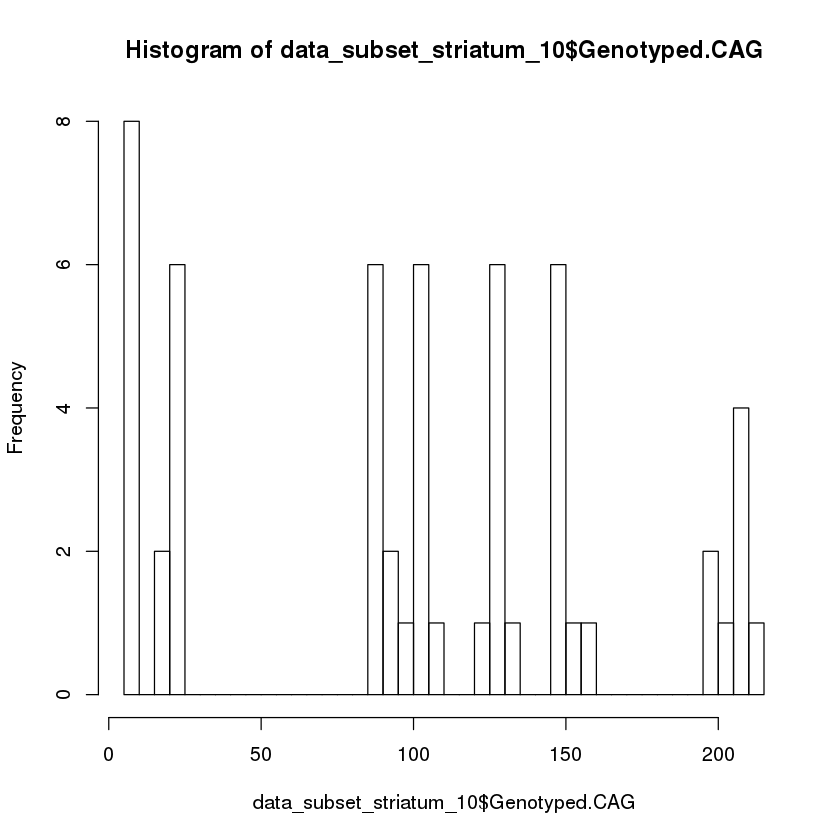

In [9]:
hist(data_subset_striatum_10$Genotyped.CAG, breaks=50)

## prepare data matriced for glmnet

In [10]:
y <- data_subset_striatum_10$Genotyped.CAG
y_q <- data_subset_striatum_10$Numeric.Q
X <- as.matrix(data_subset_striatum_10[-c(1:11)])
length(y)
dim(X)

[1] 56

[1]    56 23351

## split data into test/train and holdout
we'll look for good model parameters using cross validation on the 75% of the data in the test/train partition, and then train a final model on all of that 75% of the data, and finally test it on the held-out data that the model/parameter scan has never seen. createDataPartition does a balanced split, which is nice.

In [11]:
test_train_inds <- createDataPartition(y, p=0.75, groups=length(table(y_q)))

X_test_train <- X[test_train_inds$Resample1,]
y_test_train <- y[test_train_inds$Resample1]
X_holdout <- X[-test_train_inds$Resample1,]
y_holdout <- y[-test_train_inds$Resample1]

## scan over sparity values in the test/train data

the alpha value decides on the balance between the rdge and lasso penalties.  ridge encourages moderate coefficinet valies, and lasso encourages sparsity.

In [12]:
alpha_values <- seq(0,1,0.1)

cv_info <- data.frame()

for (alpha_value in alpha_values){
    fit.cv <- cv.glmnet(X_test_train, y_test_train, 
                        alpha = alpha_value, family='gaussian', type.measure = "deviance"
                       )
        
    best_lambda_index_lse <- match(fit.cv$lambda.1se, fit.cv$lambda)
    best_lambda_index_min <- match(fit.cv$lambda.min, fit.cv$lambda)
    cv_info <- rbind(cv_info, data.frame(
                                            alpha=alpha_value,
                                            lowest_lse=fit.cv$cvm[best_lambda_index_lse],
                                            nonzero_params_lse=fit.cv$nzero[best_lambda_index_lse],
                                            lowest_mse=fit.cv$cvm[best_lambda_index_min],
                                            nonzero_params_mse=fit.cv$nzero[best_lambda_index_min]
                                        )
                    )
}

### pick a good aplha parameter

we can look at the cross-validated accuracy of the model at different alpha values  and pick a value we like.  usually this in the one with the lowest mean swuared eror and a reasonable amount of sparsity.

In [13]:
cv_info
best_alpha <- cv_info$alpha[(match(min(cv_info$lowest_mse), cv_info$lowest_mse))]
best_alpha

,alpha,lowest_lse,nonzero_params_lse,lowest_mse,nonzero_params_mse
s40,0.0000,1021.7704,20830.0000,930.1663,20830.0000
s44,0.1000,886.0321,164.0000,744.9314,190.0000
s55,0.2000,743.4657,104.0000,644.4463,116.0000
s57,0.3000,729.9333,79.0000,627.5353,91.0000
s38,0.4000,825.2607,50.0000,669.3478,73.0000
s49,0.5000,841.9565,51.0000,715.6714,60.0000
s46,0.6000,840.0781,45.0000,710.1123,55.0000
s50,0.7000,758.2598,38.0000,661.9894,49.0000
s37,0.8000,852.5660,20.0000,712.4844,44.0000
s32,0.9000,944.5488,15.0000,715.0343,43.0000


[1] 0.3

this value is proabably not sparse enough -- to have good confidence we're not overfitting, we should proabably have fewer coefficients than data points

In [14]:
best_alpha <- 0.7

## look at CV performace at chosen alpha

In [15]:
fit.cv <- cv.glmnet(X_test_train, y_test_train, 
                        alpha = best_alpha, family='gaussian', type.measure = "deviance"
                       )

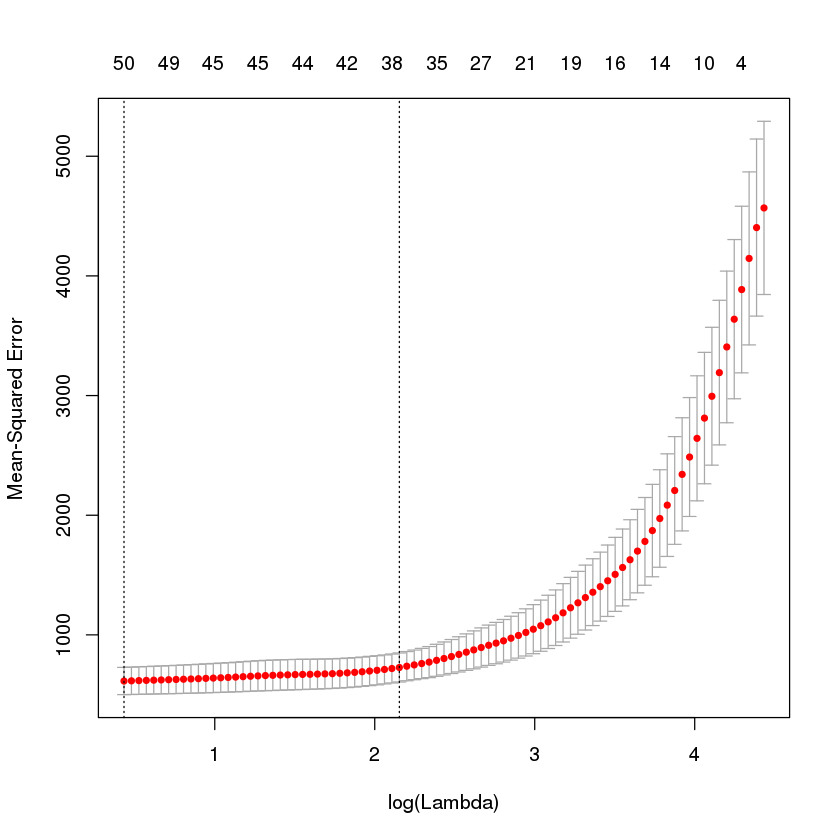

In [16]:
plot(fit.cv)

## train a final model on all the test/train data

In [17]:
fit = glmnet(X_test_train, y_test_train, alpha = best_alpha, family = 'gaussian')

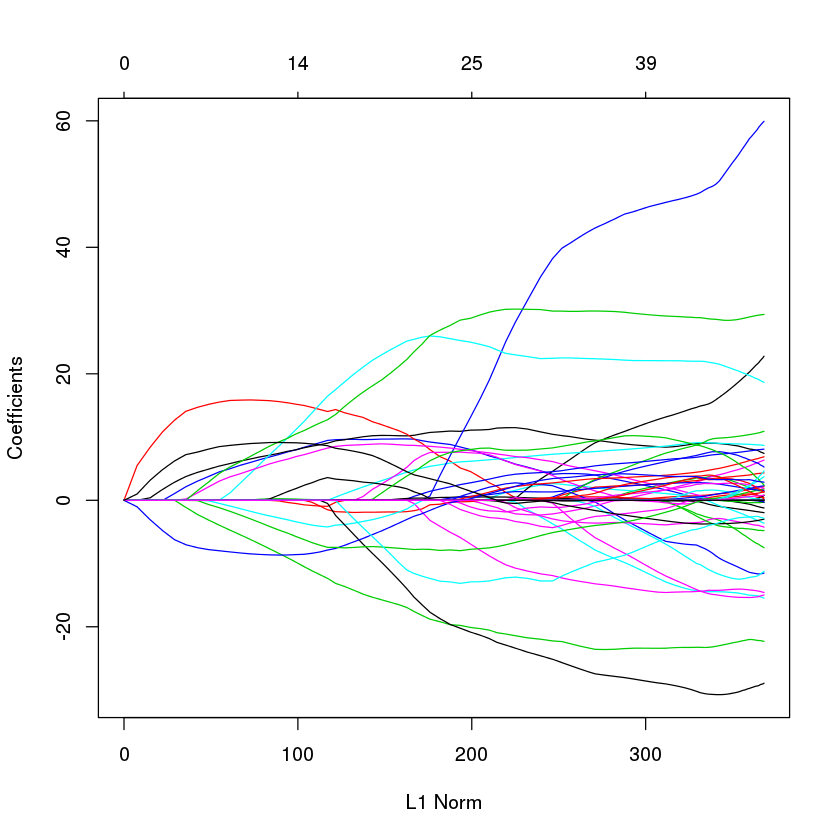

In [18]:
plot(fit)

## pick out the best model and predict with it

glmnet trains along a "lambda path" with increasing sparsity, so we need to pick the one appropriately sparse model we want.  we'll do this using the best lamda paramter from cross-validated model above.

## predictions

In [22]:
# best sparsity parameter form CV
best_lambda_index <- match(fit.cv$lambda.1se, fit.cv$lambda)

# predict on the held-out data
preds <- predict(fit, X_holdout)
y_pred <- preds[,best_lambda_index]

# create df for plotting
df_pred_perf <- data.frame(
    predicted.CAGlength=y_pred,
    actual.CAGlength=y_holdout,
    Numeric.Q=as.factor(data_subset_striatum_10$Numeric.Q[-test_train_inds$Resample1])
)


# predict on the training data, just for visualizing
preds_overfit <- predict(fit, X_test_train)
y_pred_overfit <- preds_overfit[,best_lambda_index]

# create df for plotting
df_overfit <- data.frame(
    predicted.CAGlength=y_pred_overfit,
    actual.CAGlength=y_test_train,
    Numeric.Q=as.factor(data_subset_striatum_10$Numeric.Q[test_train_inds$Resample1])
)

In [23]:
p_all <- ggplot(df_pred_perf,aes(x=actual.CAGlength, y=predicted.CAGlength)) + 

# training data
geom_point(
    data=df_overfit,
    aes(
        x=actual.CAGlength,
        y=predicted.CAGlength
        ),
    alpha = 0.1
) +

# held out data
geom_point(
    data=df_pred_perf,
    aes(colour=Numeric.Q),
    alpha = 1.0
) +

# ooh a line
stat_smooth(method = "lm", formula = y ~ x, colour="darkgrey") +

# styling
theme_minimal() +
theme(legend.position = "bottom") +
guides(col = guide_legend(nrow = 1))

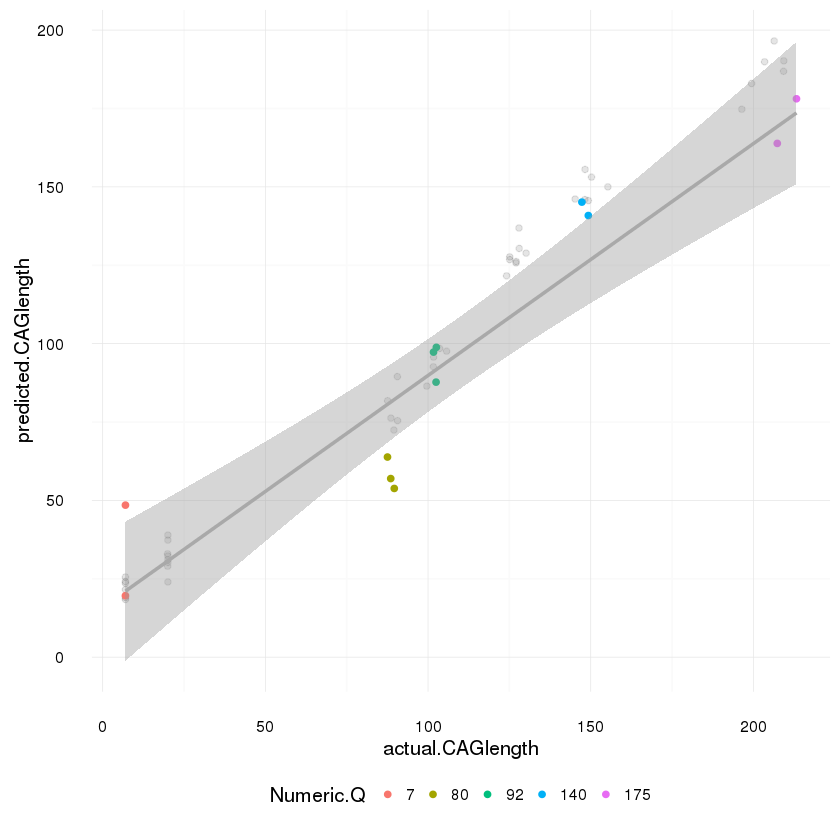

In [24]:
p_all

## pull out the nonzero coefficients and look at those genes

In [25]:
best_betas <- fit$beta[,best_lambda_index]
degs <- best_betas[best_betas != 0.0]

### make a tidy data frame of the degs for plotting

In [26]:
deg_df_log <- cbind(Numeric.Q=y_q,data.frame(X[,names(degs)]))
deg_df_log_tidy <- gather(deg_df_log, 'Gene', 'Expression', -Numeric.Q)

### plot DEG expression at each Q

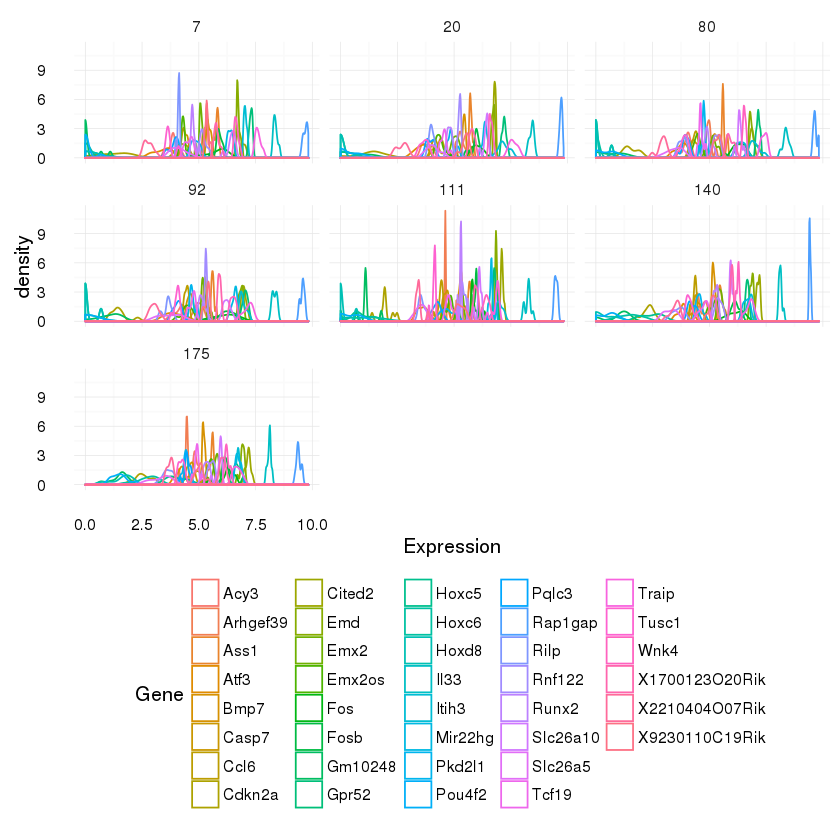

In [27]:
p_deg_log <- ggplot(deg_df_log_tidy) + 
    geom_density(aes(Expression, colour = Gene)) +
    theme_minimal() + 
    theme(legend.position = "bottom")


p_deg_log + facet_wrap(~ Numeric.Q)

### plot DEG expression for each gene colored by Q length

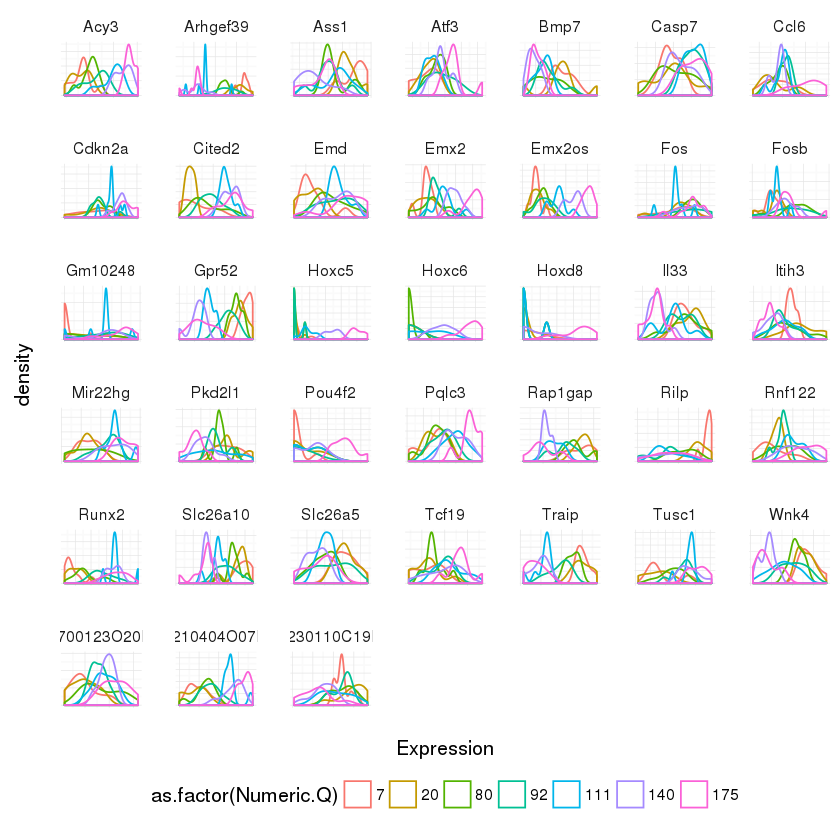

In [28]:
p_deg_log <- ggplot(deg_df_log_tidy) + 
    geom_density(aes(Expression, colour = as.factor(Numeric.Q))) +
    theme_minimal() + 
    theme(
        legend.position = "bottom",
        axis.ticks = element_blank(),
        axis.text = element_blank()
         ) +
    guides(col = guide_legend(nrow = 1))


p_deg_log + facet_wrap(~ Gene, scales = "free")

In [29]:
names(degs)

[1] "1700123O20Rik" "2210404O07Rik" "9230110C19Rik" "Acy3"         
 [5] "Arhgef39"      "Ass1"          "Atf3"          "Bmp7"         
 [9] "Casp7"         "Ccl6"          "Cdkn2a"        "Cited2"       
[13] "Emd"           "Emx2"          "Emx2os"        "Fos"          
[17] "Fosb"          "Gm10248"       "Gpr52"         "Hoxc5"        
[21] "Hoxc6"         "Hoxd8"         "Il33"          "Itih3"        
[25] "Mir22hg"       "Pkd2l1"        "Pou4f2"        "Pqlc3"        
[29] "Rap1gap"       "Rilp"          "Rnf122"        "Runx2"        
[33] "Slc26a10"      "Slc26a5"       "Tcf19"         "Traip"        
[37] "Tusc1"         "Wnk4"